In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

torch.__version__

'2.6.0+cu124'

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
from pathlib import Path
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "ISIC2018_Task3_Training_Input"
# Setup train and testing paths
# train_dir = image_path / "train"
# test_dir = image_path / "test"

In [5]:
import random
from PIL import Image

# Set seed
random.seed(42)

image_path_list = list(image_path.glob("*.jpg"))
random_image_path = random.choice(image_path_list)

# Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")


Random image path: data/ISIC2018_Task3_Training_Input/ISIC_0030246.jpg
Image class: ISIC2018_Task3_Training_Input
Image height: 450
Image width: 600


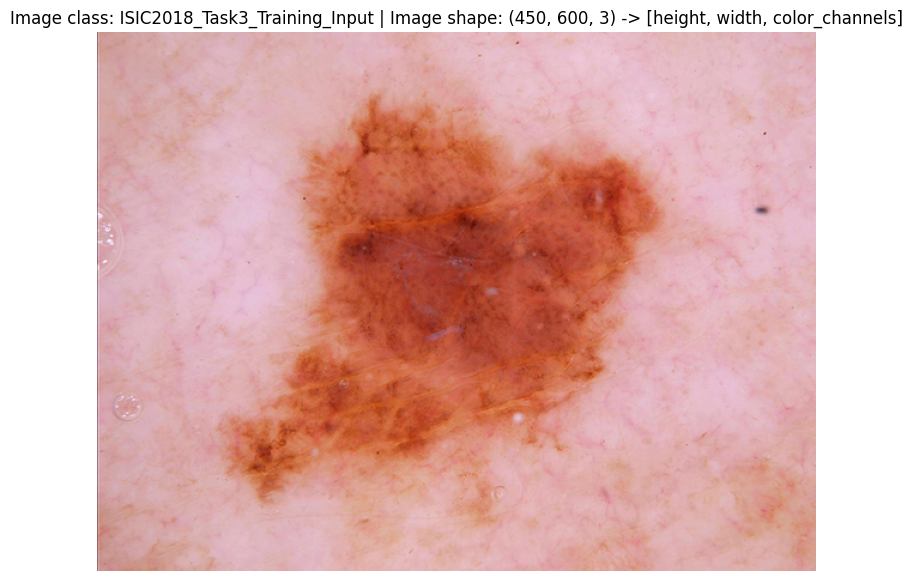

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Transform image with `torchvision.transforms`

In [7]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [8]:
data_transform(img).shape, data_transform(img), data_transform(img).shape

(torch.Size([3, 64, 64]),
 tensor([[[0.8667, 0.8706, 0.8745,  ..., 0.8157, 0.8157, 0.8000],
          [0.8667, 0.8706, 0.8784,  ..., 0.8157, 0.8078, 0.8000],
          [0.8706, 0.8745, 0.8745,  ..., 0.8196, 0.8157, 0.8000],
          ...,
          [0.8392, 0.8353, 0.8471,  ..., 0.8118, 0.7961, 0.7804],
          [0.8431, 0.8431, 0.8510,  ..., 0.8000, 0.7922, 0.7804],
          [0.8431, 0.8471, 0.8549,  ..., 0.7961, 0.7922, 0.7804]],
 
         [[0.6902, 0.6902, 0.7059,  ..., 0.6275, 0.6196, 0.6039],
          [0.6784, 0.6863, 0.6941,  ..., 0.6235, 0.6118, 0.6000],
          [0.6627, 0.6784, 0.6941,  ..., 0.6235, 0.6157, 0.6078],
          ...,
          [0.6039, 0.5765, 0.6392,  ..., 0.6118, 0.5961, 0.5686],
          [0.6157, 0.5961, 0.6471,  ..., 0.5961, 0.5804, 0.5725],
          [0.6314, 0.6157, 0.6549,  ..., 0.5725, 0.5686, 0.5608]],
 
         [[0.7216, 0.7333, 0.7529,  ..., 0.6078, 0.6000, 0.5804],
          [0.7098, 0.7216, 0.7333,  ..., 0.6039, 0.5882, 0.5843],
          [0.6

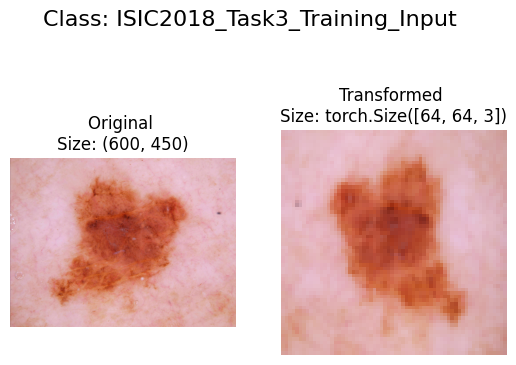

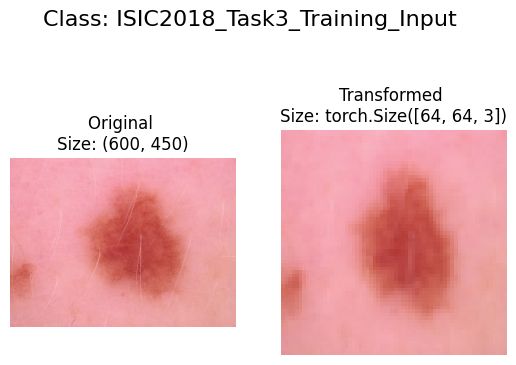

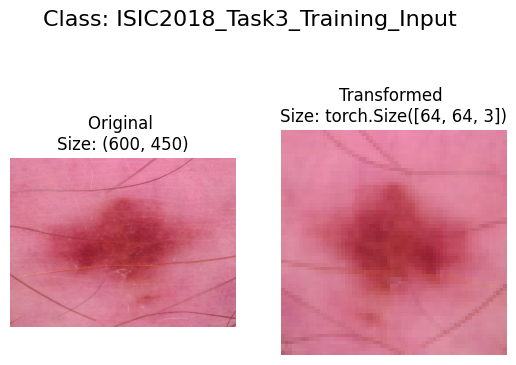

In [9]:
def plot_transformed_images(image_path, transform, n=3, seed=42):
    """Plots a series of random images from image_path.

    Will open n image paths from image_path, transform them
    with transform and plot them side by side.

    Args:
        image_path (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_path, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### Turn images into `DataLoader`

In [10]:
from sklearn.model_selection import train_test_split
import pandas as pd

metadata_file = data_path / "HAM10000_metadata.csv"
metadata_df = pd.read_csv(metadata_file)

print(metadata_df.head())

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern  


In [11]:
# 70% training, 10% validation, 20% testing 
# Split data into train and test
test_size = 0.2
val_size = 0.1
random_state=42

train_df, test_df = train_test_split(
    metadata_df, test_size=test_size, random_state=random_state, stratify=metadata_df['dx']
)

# Split train into train and validation
train_df, val_df = train_test_split(
    train_df, test_size=val_size/(1-test_size), random_state=random_state, stratify=train_df['dx']
)

In [12]:
len(train_df), len(val_df), len(test_df)

(7010, 1002, 2003)

In [13]:
import os
print(os.cpu_count())

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_df, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=val_df, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

train_dataloader, test_dataloader

16


(<torch.utils.data.dataloader.DataLoader at 0x7317eb35d870>,
 <torch.utils.data.dataloader.DataLoader at 0x7318f87d3850>)

In [14]:
len(train_dataloader), len(test_dataloader)

(7010, 1002)

### Create Custom DataSet Class in PyTorch

In [ ]:
# SkinDataset.py